# Effects  of a non-linear PFD-CP in the output spectrum of a fractional PLL

## Library imports

In [1]:
# Compatibility with python 3.0
from __future__ import division

# Array Computation and basic functions
import numpy as np
from numpy import (ones, log10, sin, pi, tan, sqrt)

# Plotting 
import matplotlib.pyplot as plt
import matplotlib
## plotting settings
%matplotlib inline
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['figure.figsize']  = (9,6)
matplotlib.rcParams['axes.labelsize'] = 'large'
matplotlib.rcParams['axes.grid'] = True

# Signal processing
import scipy.signal as sig
import scipy.fftpack as fft

# Add the pnoise and pll modules 
import plldesigner.pnoise as pn
import plldesigner.sdmod as sdmod

# Linear time invariant system routines
import scipy.signal.ltisys as lti

## Introduction
This notebook shows how to asset the effects of the non-linear components of a phase detector in the phase noise characteristic of a fractional-N PLL. To do the computation we will use  Python and the [plldesigner](https://github.com/jfosorio/plldesigner) toolbox.

In the previous entry the phase noise introduced by using a MASH $\Sigma-\Delta$ modulator in a fractional-N frequency synthesizer using a linear phase detector was studied [1](http://jfosorio.github.io/blog/2014/06/09/sigma-delta-modulator-phase-noise-in-fractional-n-plls/), we will complement that with the analysis of the noise folding shown here.

This analysis will be focus in a phase detector using the conventional PFD-CP but most of the reasoning would apply to any other type of detector. 

In PFD-CP comparators the non-linearity is due mainly to three different aspects: first, the PFD-CP dead-zone creates an abroupt change in the phase transfer function when the phase error is close to zero. Second, the difference between up and down currents create differences between the slope of the curve for positive and negative phase errors. Third, the CP finite output impedance creates dependence of the pumped current with the output voltage.

A simple,  method to assest the noise is first demonstrated in [Muer2003] and is shown in Fig.1. This method is fast because it allows to calculate the power spectral density without the feedback branch of the circuit.

<br>
<img src="images/Linearity_technique.png" alt="Technique to predict noise folding" width="600">
<center> Figure 1. Technique to calculate the effect of the linearity in the noise </center>

The function $g_{CP}(out)$ is defined as the function that captures the linearity of the CP or in general the phase detector. For a given input $\phi$ it returns  the equivalent $\phi_{out}$ that would be required at the input of the phase detector to produce the current observed using $\phi$. This function can founded by sweeping the difference delay of the reference and the divider signal at the input of the PFD and mesuring the output of the CP, $i_{CP}(t, \phi)$, and calculating the average current over a period $g_{CP}(\tau)$, scaled by the total current $I_{CP}$, as:

\begin{equation}
g_{CP}(\phi) = \frac{1}{I_{CP}} \frac{1}{T_{ref}} \int_T i_{cp}(t,\phi) dt.
\end{equation}

The power spectral density (PSD) of the phase noise, referred to the input, can be calculated then by using the FFT. This method accounts for the first two type of artifacts but it can not fully reproduce the fact that the linearity changes dynamically with the output voltage of the CP, where full loop simulations is necessary.  Even with this limitation we can use the method to assets fast the effects of the different non-linear artifacts in the power spectrum density of the PLL.

## Calculating $\phi_{error}$
In order to calculate $\phi_{error}$ we recall the expression for the instantaneous frequency frequency deviation at the output of the fractional divider using a $\Delta-\Sigma$ modulator,  as shown  in the previous notebook: 

\begin{equation}
   \Delta_{f_{div}(z)} = \frac{f_{in}}{N+f(z)}\left(1 - \frac{H_s(z) \Delta_{q}(z)}{N+f(z)}\right),
\end{equation}

where $f_{in}$ is the frequency at the input of the divider and  $H_s(z) \Delta_{q}(z)$ is the instantaneous changes made by the SDM.  The quantity $H_s(z) \Delta_{q}(z)$ can be also represented as $\Delta_{N}(z)-f(z)$, this is the raw output of the SDM, $\Delta_N(z)$,  minus the desired fractional value, $f(z)$. Given than we are interested only in the frequency error, it is possible to write an expression for the frequency error: 

\begin{equation}
e_{f,err}(z) = \frac{f_{in}}{N+f(z)}\left(\frac{\Delta_{N}(z)-f(z)}{N+f(z)}\right),
\end{equation}

by integrating we can find the phase error at the output of the divider:

\begin{equation}
\phi_{error}(z) = 2 \pi f_{ref} \left(\frac{\Delta_{N}(z)-f(z)}{N+f(z)}\right) \frac{T_{ref}}{1-z^{-1}},
\end{equation}
that can be further simplified as:

\begin{equation}
\phi_{error}(z) = 2 \pi \frac{1}{1-z^{-1}} \left(\frac{\Delta_{N}(z)-f(z)}{N+f(z)}\right).
\end{equation}

Last expression allows to calculate $\phi_{error}(z)$ from the raw data of the $\Sigma-\Delta$ modulator under the assumption that the error

## Generating the SDM sequence
In order to generate the phase error sequence we can use the methods used in the previous entry [1](http://jfosorio.github.io/blog/2014/06/09/sigma-delta-modulator-phase-noise-in-fractional-n-plls/). This is shown in the next code.

fractional part 0.253223


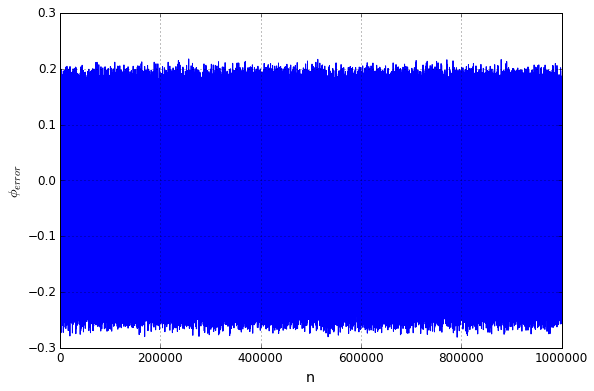

In [2]:
# Parameters 
NsdBits = 19
fref = 27.6e6
Tref = 1.0/fref
Navg = 50.253223
Nint = np.floor(Navg)
# fractional part
alpha = Navg-int(Navg)
print('fractional part {}'.format(alpha))

# Create a SDM sequence 
fracnum = ((alpha*2**NsdBits)*ones(1000000)).astype(int)
sd, per = sdmod.gen_mash(3,NsdBits,fracnum)

# Phi_er at the output equals \sum{\DeltaN*fref}*Tref
phi_err = 2*pi*(sd-fracnum[0]/2**NsdBits).cumsum()/Navg
plt.xlabel('n')
plt.ylabel('$\phi_{error}$')
ax = plt.plot(phi_err)

The mean value of this phase  is removed by the loop after the system converges. Thus, after a initial transient, the output converges to:

In [3]:
# Remove the phase offset
phi_err -= phi_err.mean()

## Modeling the PFD-CP non-linearity
Lets suppose a CP with only missmatch between the positive and negative currents as shown in  the next figure. The next simple code ilustrate a function for this case.

In [4]:
# Function to model mismatch in the PFD-CP
def g(phi_er, mod=1, ip_miss=0, in_miss=0, tdead=0):
    phi_er_mod = np.fmod(phi_er,mod)
    ix_dead = (abs(phi_er_mod) < tdead/2) |  ((1-abs(phi_er_mod)) <tdead/2)
    phi_er_mod[ix_dead] = 0
    phi_out = np.copy(phi_er_mod)
    ixp = phi_er_mod > 0
    ixn = phi_er_mod < 0
    phi_out[ixp] = (1+ip_miss)*phi_out[ixp]
    phi_out[ixn] = (1+in_miss)*phi_out[ixn]
    return phi_out
# suppose that the positive current is 10% larger than expected
# and the negative one 10% smaller
g_miss = lambda phi : g(phi, 1, 0.1, -0.1, 0.00)

Lets plot the function we creater for different offsets

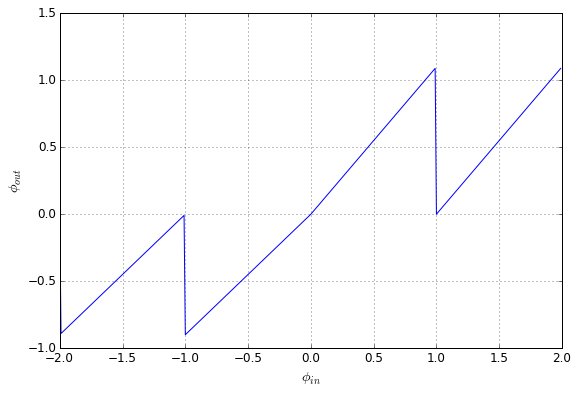

In [5]:
## plotting the transfer function of the PFD-CP
phi_error = np.arange(-2,2,0.01)
plt.xlabel('$\phi_{in}$')
plt.ylabel('$\phi_{out}$')
ax = plt.plot(phi_error,g_miss(phi_error))

## Phase after distortion by the CP non-linear transfer function
It is illustrative to plot the effect of the CP on the phase error as expected the errors introduced reduce the current for positive values of the phase error and increases the absolute current for the negative values. 

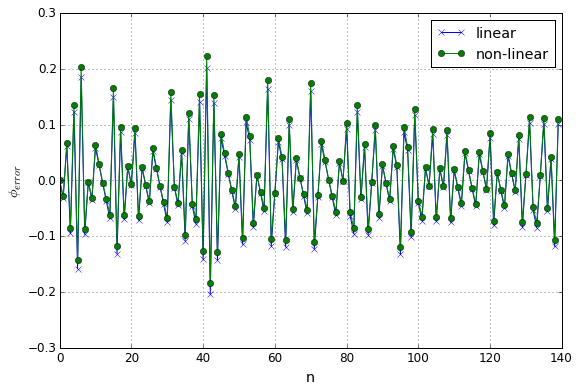

In [6]:
## Apply the non-linear function to phi_err
phi_err_nonlin = g_miss(phi_err)

# Plotting
plt.xlabel('n')
plt.ylabel('$\phi_{error}$')
plt.plot(phi_err[0:140],'-x', label ='linear')
ax = plt.plot(phi_err_nonlin[0:140],'-o', label= 'non-linear')
leg = plt.legend()

In order to calculate the power spectrum density we use the welch method and the FFT as in previous notebooks.

rbw 1684.5703125


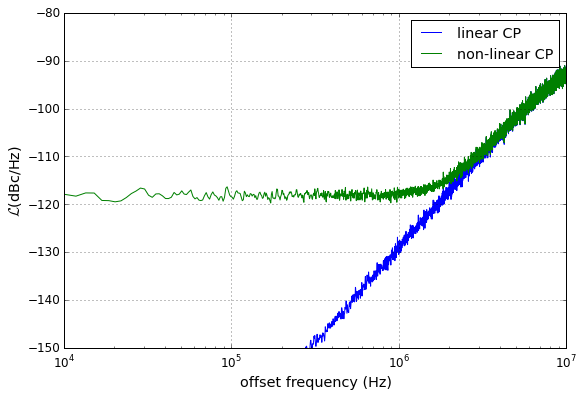

In [7]:
# Calculate th spectrum
nperseg = 2**14
## The SSB power spectrum can be calculated using the welch algorithm
f, Phi2_err = sig.welch(phi_err, fref, window='blackman', 
                        nperseg=nperseg)


f, Phi2_err_nonlin = sig.welch(phi_err_nonlin, fref, window='blackman',
                               nperseg=nperseg)

rbw = fref/2/(len(f)-1)
print('rbw {}'.format(rbw))
ind = f<1e10

# ploting 
def plt_pnoise(fm, Lfm, label=""):
    '''Function to plot phase noise'''
    ax = plt.semilogx(fm, Lfm, label = label)
    plt.xlabel('offset frequency (Hz)')
    plt.ylabel('$\mathcal{L}$(dBc/Hz)')
    return ax

plt_pnoise(f[ind],10*log10(Phi2_err[ind]/2), label='linear CP')
plt_pnoise(f[ind],10*log10(Phi2_err_nonlin[ind]/2), label='non-linear CP')
plt.xlim(1e4, 1e7)
plt.ylim([-150, -80])
leg = plt.legend(loc=0)

## Effect of the PFDCP dead time 
Normally PFD based in CP have a dead time region that is usually avoided with a offset current of other similar mechanism. In order to evaluate the effect in the power spectral density we use the same method than before. 
Lets assume a CP as the one shown in the next figure:

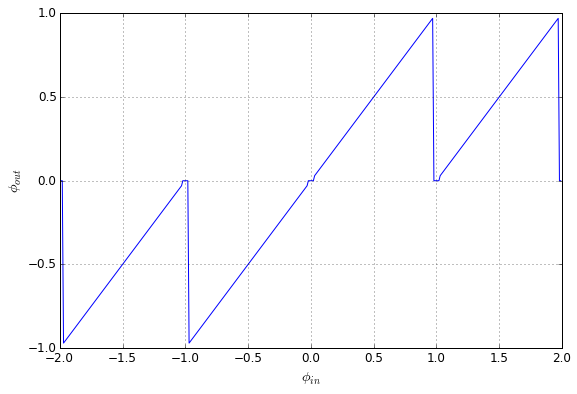

In [8]:
g_miss = lambda phi : g(phi, 1, 0.0, 0.0, 0.05)
## plotting the transfer function of the PFD-CP
phi_error = np.arange(-2,2,0.01)
plt.xlabel('$\phi_{in}$')
plt.ylabel('$\phi_{out}$')
ax = plt.plot(phi_error,g_miss(phi_error))

Lets plot the linear vs non-linear characteristic of the CP. Notice that as an effect of the CP dead region in points close to $\phi_{error} \approx 0 $ the CP becomes unresponsive. This not only increase the CP noise floor but creates fractional spurs as will be notice after plotting the spectrum.

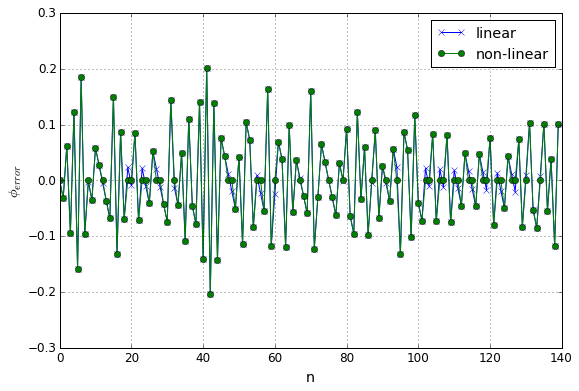

In [9]:
## Apply the non-linear function to phi_err
phi_err_nonlin = g_miss(phi_err)
# Plotting
plt.xlabel('n')
plt.ylabel('$\phi_{error}$')
plt.plot(phi_err[0:140],'-x', label ='linear')
ax = plt.plot(phi_err_nonlin[0:140],'-o', label= 'non-linear')
leg = plt.legend()

rbw 1.685(KHz)  32.265(dB)


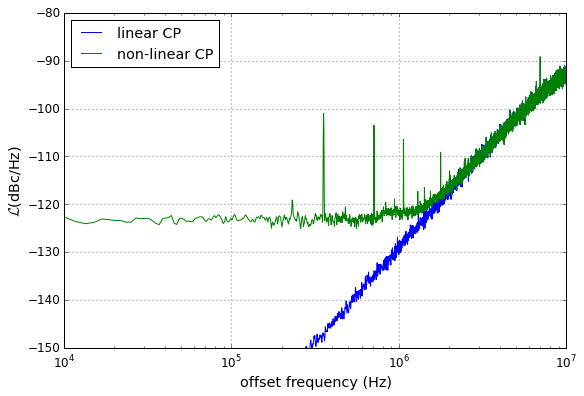

In [10]:
## Calculate the power spectrum density
f, Phi2_err_nonlin = sig.welch(phi_err_nonlin, fref, window='blackman',
                               nperseg=nperseg)

rbw = fref/2/(len(f)-1)
print('rbw {:2.3f}(KHz)  {:2.3f}(dB)'.format(rbw/1e3, 10*log10(rbw)))
ind = f<1e10

## ploting the PSD
plt_pnoise(f[ind],10*log10(Phi2_err[ind]/2), label='linear CP')
plt_pnoise(f[ind],10*log10(Phi2_err_nonlin[ind]/2), label='non-linear CP')
plt.xlim(1e4, 1e7)
plt.ylim([-150, -80])
leg = plt.legend(loc=0)

The amplitude of the spurs has to be corrected by the rbw in this case 32dBs and by the fact that the DSB power spectrum is 6dB lower for conherent signal compared to the SSB. The figure is, on the other hand, scaled to see the power spectral density for non-coherent noise, so the DSB is a factor of -3dB lower than the SSB power spectral density, then if we read the spur from the figure the spur level will be -3dB lower:

The power of the spur: 
\begin{equation}
A_{sp}(dBc) = A_{sp}(dBc/Hz) + \text{rbw}(dB) - 3dB. 
\end{equation}

 For the spur around 35Khz this value is around -70dBc. 

The spurs are located at multiples of frequencies: 
$$
f_{sp} = n \alpha f_{ref}, (1-n\alpha) f_{ref} \, \, \forall n={0, 1, 2, 3, ...}
$$
The spurs and the the noise calculated here is *input referred* meaning that this is the equivalent of this noise, and spurs, at the input of the PLL. Depending of the frequency response of the PLL and its multiplication factor this noise will be filtered and scaled.

## Response of the PLL to the sigma delta noise

The most communly used analog PLL are type-II PLL's. Those PLLs have a perfect extra integrator, additional to the phase integration due to the VCO. In this section we would compare the effects of PLL, second and third order filter.

## Third order PLL
The open loop transfer function of a third order system is given by: 

\begin{equation}
    G(s)=  K \cfrac{st_z +1}{s^2(s t_p+1)},
\end{equation}

Where K is the complete gain of the loop and the factor $s^2$ appears due to a ideal integrator due to the filter and the integration due to the VCO.

The close loop transfer function, assuming a unitary gain, is given by:
\begin{equation}
    H(s)=  K \cfrac{st_z +1}{t_p s^3 +  s^2 + K s t_z + K}
\end{equation}

A simple method to design this filter is defining the phase margin $\psi_m$ and  cutoff frequency $f_c$ of the open loop transfer. It can be demonstrated that the pole the zero and the gain that achieve this phase margin with minimal ratio between the pole and the zero can are given by:

\begin{equation}
b = \tan \left(\frac{1}{2} \phi_m  \frac{\pi}{180} + \pi /4 \right)^2
\end{equation}

\begin{equation}
t_z = \frac{\sqrt{b}}{2\pi f_c}
\end{equation}

\begin{equation}
t_p = \frac{1}{2\pi f_c \sqrt{b}}
\end{equation}

\begin{equation}
K = \frac{(2\pi f_c)^2}{\sqrt{b}}
\end{equation}

The following lines of code show that the open loop and close loop gain for the different phase margins and you can check in the annex that they give the right transfer function.

In [11]:
def sys_3order(pm=60, fc=1):
    b = (tan(pm*pi/180/2+pi/4))**2;
    wc = 2*pi*fc
    tz = sqrt(b)/wc
    tp = 1/(wc*sqrt(b))
    K = wc**2/sqrt(b)
    Gsys = lti.lti([K*tz, K],[tp, 1, 0, 0])
    Hsys = lti.lti([K*tz, K],[tp, 1, K*tz, K])
    return Gsys, Hsys

The other term that is necessary to include is the loop multiplication ratio. The loop multiplication ratio $M$ is normally equal or higher than the average value $N_{avg}$. This is because the VCO might have a pre-scaler that does not dither the output frequency.

\begin{equation}
M = N_{fix} \, N_{avg}
\end{equation}

The noise due to the Sigma Delta modulator can be found as: 

\begin{equation}
\mathcal{L}_{out}(f_m)= \mathcal{L}_{in}(f_m)\,  H(f_m) \, N_{fix} \, N_{avg}
\end{equation}

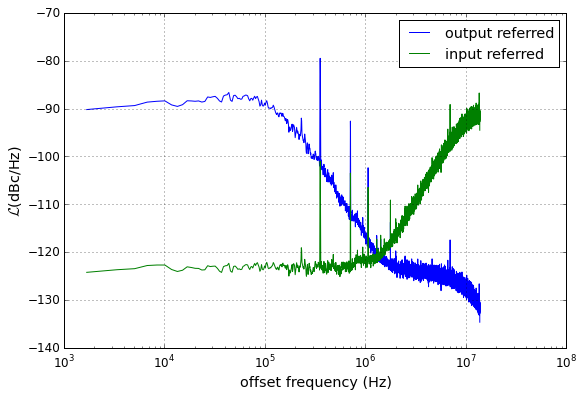

In [12]:
Gsys, Hsys = sys_3order(pm=60, fc = 1e5)
Nfix = 1
M = Nfix*Navg
wm, Hfm = Hsys.freqresp(w=2*pi*f[ind])
plt_pnoise(f[ind],10*log10(Phi2_err_nonlin[ind]/2) + 20*log10(abs(Hfm)) + 20*log10(M), label='output referred')
plt_pnoise(f[ind],10*log10(Phi2_err_nonlin[ind]/2), label='input referred')
plt.legend();

## Conclusion
A method to study the effects of the linearity of the PFDCP in a fractional-N PLL was illustrated using python. It was shown that the differences in gain of the *up* and *down* currents do not result in spurs for this particular case. On the other hand the dead time result immediately in large spurs.

## References

[1] De muer Bram and M. Steyaert, CMOS Fractional-N Synthesizers: Design for High Spectral Purity and Monolithic Integration. Springer Science & Business Media, 2003.

[2] H. Schmid, “How to use the FFT and Matlab’s pwelch function for signal and noise simulations and measurements.” .


[3] C. S. Vaucher, Architectures for RF Frequency Synthesizers. Springer, 2002.

## Download

[get the notebook](https://github.com/jfosorio/plldesigner/blob/master/notebooks/Linearity.ipynb)


##  Annex:  Calculating the power spectral density by using the FFT
The FFT can also be used to calculate the power spectral density with the main disadvantage the that it is necesary to judge output because resulting spectrum plot is noisy. 

The power spectrum density can be calculated from the FFT as[2]:

\begin{equation}
S_{xx}[0] =\frac{Y_{xx}[0] \cdot Y_{xx}[0]^*}{ \sum_{i=0}^{N-1} w[i]^2 \cdot f_s}
\end{equation}

\begin{equation}
S_{xx}[n] = \frac{2 Y_{xx}[n] \cdot Y_{xx}[n]^*}{\sum_{i=0}^{N-1} w[i]^2 \dot f_s} \qquad n>0
\end{equation}

Where $f_s$ is the sampling frequency, that for this particular case equals the reference frequency,  $w[i]$ is the window applicated to the signal and $Y_{xx}[i]$ is the result of the FFT as given by numpy and matlab.


rbw 0.028(KHz)  14.409(dB)


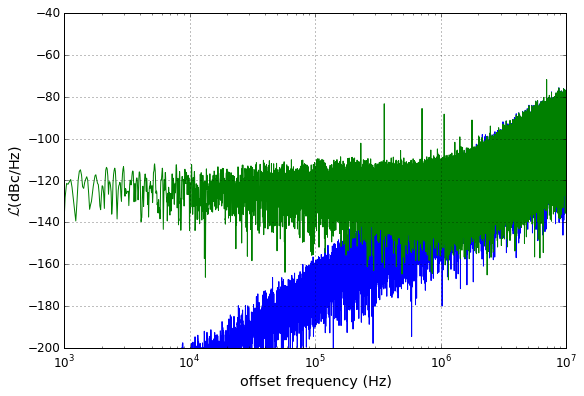

In [13]:
L = len(phi_err)
N=L
fs = fref
# flattop window is good for detecting spurs
w = sig.flattop(L)
# Calculate the power spectral density
Yx = fft.fft(w*phi_err, N)


Nhalf = int(N/2)
Sxx = abs(Yx[0:Nhalf]*Yx[0:Nhalf].conj()/sum(w**2)/fs)
Sxx[1:] = abs(2*Sxx[1:])
f = np.linspace(0, fs/2, len(Sxx))
plt_pnoise(f, 10*log10(Sxx), label = 'linear')

rbw = f[1]-f[0]
print('rbw {:2.3f}(KHz)  {:2.3f}(dB)'.format(rbw/1e3, 10*log10(rbw)))

Yx = fft.fft(w*phi_err_nonlin, N)

Sxx = abs(Yx[0:Nhalf]*Yx[0:Nhalf].conj()/sum(w**2)/fs)
Sxx = abs(2*Sxx[1:])
f = np.linspace(0, fs/2, len(Sxx))

plt_pnoise(f, 10*log10(Sxx), label="non-linear")
plt.ylim([-200, -40])
ax = plt.xlim([1e3, 1e7])


## Annex Third order PLL transfer functions

In [14]:
pm_v = [30, 40, 60, 70]
sys_v = [sys_3order(pm) for pm in pm_v]

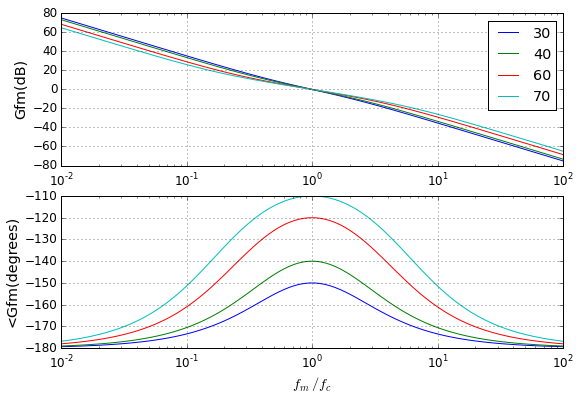

In [15]:
fm = np.logspace(-2, 2, 100)
# Plot  GM for different offsets
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
for sys, pm in zip(sys_v, pm_v): 
    a = sys[0]
    w, Gfm = sys[0].freqresp(w=2*pi*fm)
    ax1.semilogx(fm, 10*log10(abs(Gfm)**2), label='{}'.format(pm))
    ax2.semilogx(fm, 180/pi*np.unwrap(np.angle(Gfm)))
ax1.set_ylabel('Gfm(dB)')
ax1.legend()
ax2.set_ylabel('<Gfm(degrees)')
ax2.set_xlabel('$f_m/f_{c}$');

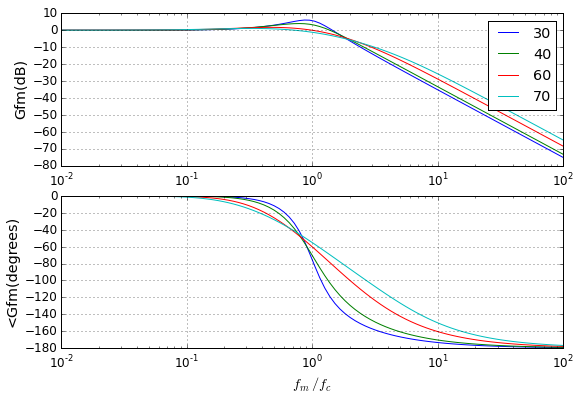

In [16]:
# Plot  GM for different offsets
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
for sys, pm in zip(sys_v, pm_v): 
    a = sys[0]
    w, Hfm = sys[1].freqresp(w=2*pi*fm)
    ax1.semilogx(fm, 10*log10(abs(Hfm)**2), label='{}'.format(pm))
    ax2.semilogx(fm, 180/pi*np.unwrap(np.angle(Hfm)))
ax1.set_ylabel('Gfm(dB)')
ax1.legend()
ax2.set_ylabel('<Gfm(degrees)')
ax2.set_xlabel('$f_m/f_{c}$');